In [2]:
import fastf1
import os

# 1. Define the folder name
cache_folder_name = 'cache'

# 2. CRITICAL STEP: Create the folder if it doesn't exist yet
if not os.path.exists(cache_folder_name):
    os.makedirs(cache_folder_name)

# 3. Now it is safe to enable the cache
fastf1.Cache.enable_cache(cache_folder_name) 

print("Cache enabled successfully!")

Cache enabled successfully!


In [3]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Enable Cache (Crucial for speed)
fastf1.Cache.enable_cache('cache') 

def get_race_data(year, gp_name):
    # Load the session
    session = fastf1.get_session(year, gp_name, 'R')
    session.load()
    return session

# Example: Load Bahrain 2023
session = get_race_data(2023, 'Bahrain')
laps = session.laps

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


# EDA

In [4]:
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:04:15.902000,VER,1,0 days 00:01:39.019000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:42.414000,...,False,Red Bull Racing,0 days 01:02:36.652000,2023-03-05 15:03:38.501,12,1.0,False,,False,False
1,0 days 01:05:53.876000,VER,1,0 days 00:01:37.974000,2.0,1.0,NaT,NaT,0 days 00:00:31.342000,0 days 00:00:42.504000,...,False,Red Bull Racing,0 days 01:04:15.902000,2023-03-05 15:05:17.751,12,1.0,False,,False,True
2,0 days 01:07:31.882000,VER,1,0 days 00:01:38.006000,3.0,1.0,NaT,NaT,0 days 00:00:31.388000,0 days 00:00:42.469000,...,False,Red Bull Racing,0 days 01:05:53.876000,2023-03-05 15:06:55.725,1,1.0,False,,False,True
3,0 days 01:09:09.858000,VER,1,0 days 00:01:37.976000,4.0,1.0,NaT,NaT,0 days 00:00:31.271000,0 days 00:00:42.642000,...,False,Red Bull Racing,0 days 01:07:31.882000,2023-03-05 15:08:33.731,1,1.0,False,,False,True
4,0 days 01:10:47.893000,VER,1,0 days 00:01:38.035000,5.0,1.0,NaT,NaT,0 days 00:00:31.244000,0 days 00:00:42.724000,...,False,Red Bull Racing,0 days 01:09:09.858000,2023-03-05 15:10:11.707,1,1.0,False,,False,True


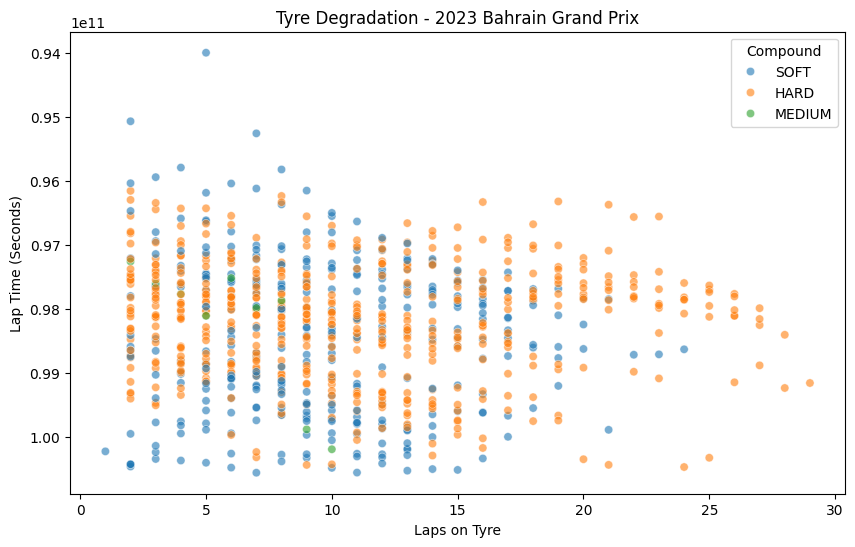

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out slow laps (Safety Car, VSC, In/Out laps) to get clean data
race_laps = session.laps.pick_quicklaps()

plt.figure(figsize=(10, 6))

# Plot: X=Tyre Age, Y=Lap Time, Color=Compound
sns.scatterplot(data=race_laps, x='TyreLife', y='LapTime', hue='Compound', alpha=0.6)

plt.title(f"Tyre Degradation - {session.event.year} {session.event.EventName}")
plt.ylabel("Lap Time (Seconds)")
plt.xlabel("Laps on Tyre")
plt.show()

In [6]:
import fastf1
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# --- 2. HELPER FUNCTIONS (The Logic) ---

def check_undercut_success(row, session):
    """
    Determines if the undercut worked.
    Logic: Did I pass the rival (who was ahead) after they eventually pitted?
    """
    driver = row['Driver']
    pit_lap = row['LapNumber']
    
    # 1. Who was ahead of me on the PREVIOUS lap?
    prev_lap = pit_lap - 1
    prev_lap_data = session.laps[session.laps['LapNumber'] == prev_lap]
    
    my_data = prev_lap_data[prev_lap_data['Driver'] == driver]
    if my_data.empty: return 0
    my_pos = my_data['Position'].values[0]
    
    if my_pos == 1: return 0 # P1 cannot undercut
    
    rival_data = prev_lap_data[prev_lap_data['Position'] == (my_pos - 1)]
    if rival_data.empty: return 0
    rival_driver = rival_data['Driver'].values[0]
    
    # 2. Did the rival pit within the "Undercut Window" (next 3 laps)?
    rival_pits = session.laps[
        (session.laps['Driver'] == rival_driver) & 
        (session.laps['PitInTime'].notna()) & 
        (session.laps['LapNumber'] > pit_lap) & 
        (session.laps['LapNumber'] <= pit_lap + 7)
    ]
    
    if rival_pits.empty: return 0 # Rival stayed out, strategy failed or didn't apply
        
    # 3. Who came out ahead?
    rival_stop_lap = rival_pits['LapNumber'].values[0]
    check_lap = rival_stop_lap + 1 # The lap after rival's stop
    
    check_lap_data = session.laps[session.laps['LapNumber'] == check_lap]
    
    try:
        my_new_pos = check_lap_data[check_lap_data['Driver'] == driver]['Position'].values[0]
        rival_new_pos = check_lap_data[check_lap_data['Driver'] == rival_driver]['Position'].values[0]
        
        return 1 if my_new_pos < rival_new_pos else 0
    except IndexError:
        return 0

In [7]:
def get_gap_to_rival(row, session):
    """
    Calculates time gap (in seconds) to the car ahead just before pitting.
    """
    driver = row['Driver']
    lap = row['LapNumber']
    prev_lap = lap - 1
    
    lap_data = session.laps[session.laps['LapNumber'] == prev_lap]
    
    my_data = lap_data[lap_data['Driver'] == driver]
    if my_data.empty: return None
    my_time = my_data['Time'].values[0]
    my_pos = my_data['Position'].values[0]
    
    if my_pos == 1: return 0 # No rival ahead
    
    rival_data = lap_data[lap_data['Position'] == (my_pos - 1)]
    if rival_data.empty: return None
    rival_time = rival_data['Time'].values[0]
    
    # --- FIX IS HERE ---
    # We force the result back into a Pandas Timedelta so we can use .total_seconds()
    gap = pd.Timedelta(my_time - rival_time)
    
    return gap.total_seconds()

def check_traffic(row, session):
    """
    Checks if the driver re-joins into traffic (cars within +/- 1.5s).
    """
    driver = row['Driver']
    lap = row['LapNumber']
    pit_out_time = row['PitOutTime']
    
    if pd.isna(pit_out_time): return 0
        
    # Traffic Bubble: 1.5 seconds around pit exit
    buffer = pd.Timedelta(seconds=1.5)
    
    # Look at OTHER drivers on the SAME lap
    others = session.laps[
        (session.laps['LapNumber'] == lap) & 
        (session.laps['Driver'] != driver)
    ]
    
    in_traffic = others[
        (others['Time'] >= (pit_out_time - buffer)) & 
        (others['Time'] <= (pit_out_time + buffer))
    ]
    
    return 1 if len(in_traffic) > 0 else 0

In [8]:
# --- 3. MAIN DATA PIPELINE ---

def build_dataset(year, gp, session_type='R'):
    print(f"Loading {year} {gp}...")
    session = fastf1.get_session(year, gp, session_type)
    session.load()
    
    laps = session.laps
    
    # A. Pre-calculate "Next Values" (Look Ahead)
    # -------------------------------------------------
    # Shift these columns UP by 1 to align 'Next Lap' data with 'Current Lap' row
    laps['NextLapTime'] = laps.groupby('Driver')['LapTime'].shift(-1)
    laps['NextPitOutTime'] = laps.groupby('Driver')['PitOutTime'].shift(-1)
    laps['NewCompound'] = laps.groupby('Driver')['Compound'].shift(-1)
    
    # B. Filter for Pit Stops
    # -------------------------------------------------
    # A row is a pit stop if 'PitInTime' is present
    pit_stops = laps[laps['PitInTime'].notna()].copy()
    
    # C. Calculate Basic Features
    # -------------------------------------------------
    # Stationary Duration (NextPitOut - PitIn)
    pit_stops['StationaryDuration'] = (pit_stops['NextPitOutTime'] - pit_stops['PitInTime']).dt.total_seconds()
    
    # In-Lap and Out-Lap Paces
    pit_stops['InLap_Sec'] = pit_stops['LapTime'].dt.total_seconds()
    pit_stops['OutLap_Sec'] = pit_stops['NextLapTime'].dt.total_seconds()
    
    # Rename Old Compound
    pit_stops = pit_stops.rename(columns={'Compound': 'OldCompound', 'TyreLife': 'TyreAge_In'})
    
    # D. Calculate Advanced Features (Apply Functions)
    # -------------------------------------------------
    print("Calculating Target (Undercut Success)...")
    pit_stops['Undercut_Successful'] = pit_stops.apply(lambda row: check_undercut_success(row, session), axis=1)
    
    print("Calculating Gap to Ahead...")
    pit_stops['Gap_To_Ahead'] = pit_stops.apply(lambda row: get_gap_to_rival(row, session), axis=1)
    
    print("Calculating Traffic...")
    pit_stops['Is_Traffic'] = pit_stops.apply(lambda row: check_traffic(row, session), axis=1)
    
    # E. Cleanup
    # -------------------------------------------------
    # Select final columns
    features = [
        'Driver', 'LapNumber', 
        'Gap_To_Ahead', 'TyreAge_In', 'OldCompound', 'NewCompound', 
        'StationaryDuration', 'InLap_Sec', 'OutLap_Sec', 'Is_Traffic',
        'Undercut_Successful'
    ]
    
    df = pit_stops[features].dropna() # Drop rows with missing data
    return df

In [9]:
import fastf1
import pandas as pd
import time

# List of years to process
years = [2022, 2023, 2024] 

all_races_data = []

for year in years:
    # 1. Get the calendar for the year
    schedule = fastf1.get_event_schedule(year)
    
    # Filter for only official races (excluding Pre-Season Testing)
    # We look for events that have a valid 'Session5' (which is usually the Race)
    # or just filter by EventFormat usually being 'conventional' or 'sprint'
    race_events = schedule[schedule['EventFormat'] != 'testing']
    
    print(f"\n--- Processing Season {year} ({len(race_events)} races) ---")
    
    for _, event in race_events.iterrows():
        gp_name = event['EventName']
        round_num = event['RoundNumber']
        
        # Skip if the race hasn't happened yet (for current season)
        # FastF1 usually returns empty data or future dates, but safety check:
        if pd.isna(event['Session5Date']): 
            continue
            
        print(f"  > Round {round_num}: {gp_name}...", end=" ")
        
        try:
            # CALL YOUR EXISTING FUNCTION HERE
            # (Assumes 'build_dataset' from previous step is defined)
            race_df = build_dataset(year, gp_name)
            
            # Add a column for context
            race_df['Year'] = year
            race_df['GP_Name'] = gp_name
            
            all_races_data.append(race_df)
            print("Done.")
            
        except Exception as e:
            # If a race crashes (e.g., cancelled race, server error), print why and keep going
            print(f"SKIPPED. Reason: {e}")
            
# --- CONSOLIDATE ---
if all_races_data:
    master_dataset = pd.concat(all_races_data, ignore_index=True)
    print("\nSUCCESS! Master dataset built.")
    print(f"Total Pit Stops Collected: {len(master_dataset)}")
    
    # Optional: Save to CSV so you don't have to run this again
    master_dataset.to_csv('f1_undercut_data_2022_2025.csv', index=False)
    print("Saved to 'f1_undercut_data_2022_2025.csv'")
else:
    print("No data collected.")

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



--- Processing Season 2022 (22 races) ---
  > Round 1: Bahrain Grand Prix... Loading 2022 Bahrain Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 2: Saudi Arabian Grand Prix... Loading 2022 Saudi Arabian Grand Prix...


core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 3: Australian Grand Prix... Loading 2022 Australian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.140000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 4: Emilia Romagna Grand Prix... Loading 2022 Emilia Romagna Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '31', '24', '6', '47', '3', '14', '55']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 5: Miami Grand Prix... Loading 2022 Miami Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '44', '77', '31', '23', '18', '14', '22', '3', '6', '47', '20', '5', '10', '4', '24']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 6: Spanish Grand Prix... Loading 2022 Spanish Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	Fixed incorrect tyre stint information for driver '55'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WAR

Calculating Traffic...
Done.
  > Round 7: Monaco Grand Prix... Loading 2022 Monaco Grand Prix...


core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '24'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
core        WARNING 	Fixed incorrect tyre stint information for driver '20'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63',

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 8: Azerbaijan Grand Prix... Loading 2022 Azerbaijan Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 9: Canadian Grand Prix... Loading 2022 Canadian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 10: British Grand Prix... Loading 2022 British Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information fo

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 11: Austrian Grand Prix... Loading 2022 Austrian Grand Prix...


core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '24'
core        WARNING 	Fixed incorrect tyre stint information for driver '10'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Fixed incorrect tyre stint information for driver '55'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.024000 before the recor

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 12: French Grand Prix... Loading 2022 French Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.041000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_da

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 13: Hungarian Grand Prix... Loading 2022 Hungarian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 14: Belgian Grand Prix... Loading 2022 Belgian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 15: Dutch Grand Prix... Loading 2022 Dutch Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 16: Italian Grand Prix... Loading 2022 Italian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 17: Singapore Grand Prix... Loading 2022 Singapore Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 18: Japanese Grand Prix... Loading 2022 Japanese Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 19: United States Grand Prix... Loading 2022 United States Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 20: Mexico City Grand Prix... Loading 2022 Mexico City Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 21: São Paulo Grand Prix... Loading 2022 São Paulo Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 22: Abu Dhabi Grand Prix... Loading 2022 Abu Dhabi Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.

--- Processing Season 2023 (22 races) ---
  > Round 1: Bahrain Grand Prix... Loading 2023 Bahrain Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 2: Saudi Arabian Grand Prix... Loading 2023 Saudi Arabian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_ap

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 3: Australian Grand Prix... Loading 2023 Australian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 4: Azerbaijan Grand Prix... Loading 2023 Azerbaijan Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 5: Miami Grand Prix... Loading 2023 Miami Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 6: Monaco Grand Prix... Loading 2023 Monaco Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 7: Spanish Grand Prix... Loading 2023 Spanish Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 8: Canadian Grand Prix... Loading 2023 Canadian Grand Prix...


core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 9: Austrian Grand Prix... Loading 2023 Austrian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 10: British Grand Prix... Loading 2023 British Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 11: Hungarian Grand Prix... Loading 2023 Hungarian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 12: Belgian Grand Prix... Loading 2023 Belgian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Traffic...
Done.
  > Round 13: Dutch Grand Prix... Loading 2023 Dutch Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 14: Italian Grand Prix... Loading 2023 Italian Grand Prix...


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WARNING 	Driver 55 completed the race distance 06:14.695000 before the recorded end of the session.
core        WARNING 	Driver 16 completed the race distance 06:14.511000 before the recorded end of the session.
core        WARNING 	Driver 63 completed the race distance 06:07.860000 before the recorded end of the session.
core        WARNING 	Driver 44 completed the race distance 05:48.209000 before the recorded end of the se

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 15: Singapore Grand Prix... Loading 2023 Singapore Grand Prix...


core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            IN

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 16: Japanese Grand Prix... Loading 2023 Japanese Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']
events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 17: Qatar Grand Prix... Loading 2023 Qatar Grand Prix...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '55']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Pr

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 18: United States Grand Prix... Loading 2023 United States Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 19: Mexico City Grand Prix... Loading 2023 Mexico City Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 20: São Paulo Grand Prix... Loading 2023 São Paulo Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Done.
  > Round 21: Las Vegas Grand Prix... Loading 2023 Las Vegas Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.001000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 22: Abu Dhabi Grand Prix... Loading 2023 Abu Dhabi Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.

--- Processing Season 2024 (24 races) ---
  > Round 1: Bahrain Grand Prix... Loading 2024 Bahrain Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 2: Saudi Arabian Grand Prix... Loading 2024 Saudi Arabian Grand Prix...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_d

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 3: Australian Grand Prix... Loading 2024 Australian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 4: Japanese Grand Prix... Loading 2024 Japanese Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 5: Chinese Grand Prix... Loading 2024 Chinese Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 6: Miami Grand Prix... Loading 2024 Miami Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 7: Emilia Romagna Grand Prix... Loading 2024 Emilia Romagna Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 8: Monaco Grand Prix... Loading 2024 Monaco Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 9: Canadian Grand Prix... Loading 2024 Canadian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 10: Spanish Grand Prix... Loading 2024 Spanish Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_da

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 11: Austrian Grand Prix... Loading 2024 Austrian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 12: British Grand Prix... Loading 2024 British Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 13: Hungarian Grand Prix... Loading 2024 Hungarian Grand Prix...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 14: Belgian Grand Prix... Loading 2024 Belgian Grand Prix...


core        WARNING 	Fixed incorrect tyre stint information for driver '14'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	No cached data found for 

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 15: Dutch Grand Prix... Loading 2024 Dutch Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	F

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 16: Italian Grand Prix... Loading 2024 Italian Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Done.
  > Round 17: Azerbaijan Grand Prix... Loading 2024 Azerbaijan Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 18: Singapore Grand Prix... Loading 2024 Singapore Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 19: United States Grand Prix... Loading 2024 United States Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Failed to align laps for driver

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 20: Mexico City Grand Prix... Loading 2024 Mexico City Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 21: São Paulo Grand Prix... Loading 2024 São Paulo Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 22: Las Vegas Grand Prix... Loading 2024 Las Vegas Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...


events      WARNING 	Correcting user input 'Qatar Grand Prix' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 23: Qatar Grand Prix... Loading 2024 Qatar Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.
  > Round 24: Abu Dhabi Grand Prix... Loading 2024 Abu Dhabi Grand Prix...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Calculating Target (Undercut Success)...
Calculating Gap to Ahead...
Calculating Traffic...
Done.

SUCCESS! Master dataset built.
Total Pit Stops Collected: 2071
Saved to 'f1_undercut_data_2022_2025.csv'


In [11]:
# 1. Load your saved data
filename = 'f1_undercut_data_2022_2025.csv'
print(f"Loading {filename}...")
df = pd.read_csv(filename)

# 2. Inspect the Imbalance
print("--- Total Data Distribution ---")
print(df['Undercut_Successful'].value_counts())

Loading f1_undercut_data_2022_2025.csv...
--- Total Data Distribution ---
Undercut_Successful
0    1842
1     229
Name: count, dtype: int64



Training on 1449 rows...

--- Model Report (Balanced) ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       553
           1       0.33      0.41      0.37        69

    accuracy                           0.84       622
   macro avg       0.63      0.65      0.64       622
weighted avg       0.86      0.84      0.85       622



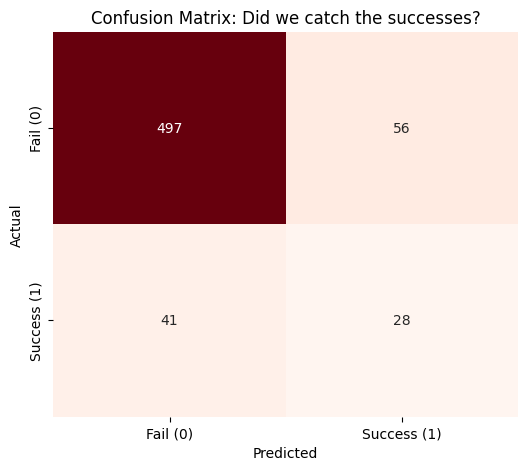

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# We use the same features as before
features = ['Gap_To_Ahead', 'StationaryDuration', 'InLap_Sec', 'OutLap_Sec', 'Is_Traffic']

# Drop N/A values to prevent crashes
ml_data = df.dropna(subset=features + ['Undercut_Successful']).copy()

X = ml_data[features]
y = ml_data['Undercut_Successful']

# 4. Split with Stratify
# 'stratify=y' ensures that if 5% of data is Success, 
# the Train and Test sets BOTH get exactly 5% Success cases.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Train with BALANCED Weights (The Fix)
print(f"\nTraining on {len(X_train)} rows...")
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    random_state=42,
    class_weight='balanced'  # <--- This tells the model: "Successes are VIPs"
)
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)

print("\n--- Model Report (Balanced) ---")
print(classification_report(y_test, y_pred))

# 7. Visual Sanity Check
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Fail (0)', 'Success (1)'],
            yticklabels=['Fail (0)', 'Success (1)'])
plt.title('Confusion Matrix: Did we catch the successes?')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
 # --- 5. MACHINE LEARNING (Random Forest) ---

if not df.empty and len(df) > 5: # Safety check
    print("\n--- Training Model ---")
    
    # Prepare Features
    X = df[['Gap_To_Ahead', 'TyreAge_In', 'StationaryDuration', 'Is_Traffic', 'OldCompound', 'NewCompound']]
    y = df['Undercut_Successful']
    
    # Encode Categorical Data (Compounds)
    le = LabelEncoder()
    # Combine both columns to fit the encoder so it knows all possible compounds
    all_compounds = pd.concat([X['OldCompound'], X['NewCompound']])
    le.fit(all_compounds)
    
    X = X.copy() # Avoid SettingWithCopy warning
    X['OldCompound'] = le.transform(X['OldCompound'])
    X['NewCompound'] = le.transform(X['NewCompound'])
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    
    # Evaluate
    preds = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("\nClassification Report:\n", classification_report(y_test, preds))
    
    # Feature Importance (What matters most?)
    importances = pd.Series(model.feature_importances_, index=X.columns)
    print("\n--- Feature Importances ---")
    print(importances.sort_values(ascending=False))

else:
    print("Not enough data gathered to train model. Try loading more races.")


--- Training Model ---
Accuracy: 0.7333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15


--- Feature Importances ---
Gap_To_Ahead          0.342094
TyreAge_In            0.324032
StationaryDuration    0.262149
OldCompound           0.039163
NewCompound           0.032562
Is_Traffic            0.000000
dtype: float64


/Users/anangayman/Documents/Binus/Data Mining AoL/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anangayman/Documents/Binus/Data Mining AoL/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anangayman/Documents/Binus/Data Mining AoL/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

In [18]:
print(df['GP_Name'].unique())

['Bahrain Grand Prix' 'Saudi Arabian Grand Prix' 'Australian Grand Prix'
 'Emilia Romagna Grand Prix' 'Miami Grand Prix' 'Spanish Grand Prix'
 'Monaco Grand Prix' 'Azerbaijan Grand Prix' 'Canadian Grand Prix'
 'British Grand Prix' 'Austrian Grand Prix' 'French Grand Prix'
 'Hungarian Grand Prix' 'Belgian Grand Prix' 'Dutch Grand Prix'
 'Italian Grand Prix' 'Singapore Grand Prix' 'Japanese Grand Prix'
 'United States Grand Prix' 'Mexico City Grand Prix'
 'São Paulo Grand Prix' 'Abu Dhabi Grand Prix' 'Qatar Grand Prix'
 'Las Vegas Grand Prix' 'Chinese Grand Prix']


In [20]:
# 1. Calculate the Median (Normal) Lap
# We group by Year, GP, and Compound to ensure fair comparison
df['Avg_Pit_Lap'] = df.groupby(['Year', 'GP_Name', 'OldCompound'])['LapNumber'].transform('median')

# 2. Calculate Aggressiveness
df['Pit_Aggressiveness'] = df['LapNumber'] - df['Avg_Pit_Lap']

# 3. View the data (This time, we just take the first 10 rows that aren't empty)
cols = ['Year', 'GP_Name', 'Driver', 'OldCompound', 'LapNumber', 'Avg_Pit_Lap', 'Pit_Aggressiveness']
print(df[cols].dropna().head(10))

   Year             GP_Name Driver OldCompound  LapNumber  Avg_Pit_Lap  \
0  2022  Bahrain Grand Prix    VER        SOFT       14.0         15.0   
1  2022  Bahrain Grand Prix    VER        SOFT       30.0         15.0   
2  2022  Bahrain Grand Prix    VER      MEDIUM       43.0         36.5   
3  2022  Bahrain Grand Prix    GAS        SOFT       14.0         15.0   
4  2022  Bahrain Grand Prix    GAS      MEDIUM       32.0         36.5   
5  2022  Bahrain Grand Prix    PER        SOFT       15.0         15.0   
6  2022  Bahrain Grand Prix    PER      MEDIUM       33.0         36.5   
7  2022  Bahrain Grand Prix    PER        SOFT       43.0         15.0   
8  2022  Bahrain Grand Prix    ALO        SOFT       11.0         15.0   
9  2022  Bahrain Grand Prix    ALO      MEDIUM       25.0         36.5   

   Pit_Aggressiveness  
0                -1.0  
1                15.0  
2                 6.5  
3                -1.0  
4                -4.5  
5                 0.0  
6                

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

# Add the new feature to the list
features = [
    'Gap_To_Ahead', 
    'Pit_Aggressiveness', # <--- The new logic
    'StationaryDuration', 
    'InLap_Sec', 
    'OutLap_Sec', 
    'Is_Traffic'
]

# Prepare Data
ml_data = df.dropna(subset=features + ['Undercut_Successful']).copy()
X = ml_data[features]
y = ml_data['Undercut_Successful']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gradient Boosting (Sklearn)
print("Training Gradient Boosting with Strategy Logic...")
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Results
y_pred = gb_model.predict(X_test)
print("\n--- Model Report ---")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- What drives the strategy? ---")
print(importances)

Training Gradient Boosting with Strategy Logic...

--- Model Report ---
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       369
           1       0.24      0.39      0.30        46

    accuracy                           0.80       415
   macro avg       0.58      0.62      0.59       415
weighted avg       0.84      0.80      0.82       415


--- What drives the strategy? ---
Gap_To_Ahead          0.433820
InLap_Sec             0.155839
OutLap_Sec            0.140564
StationaryDuration    0.138955
Pit_Aggressiveness    0.130822
Is_Traffic            0.000000
dtype: float64


--- Training Logistic Regression ---
Done.

--- Training Gradient Boosting (Sklearn) ---
Done.

--- Training Neural Network ---


/Users/anangayman/Documents/Binus/Data Mining AoL/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Done.

--- F1 Score Showdown ---
Logistic Regression: 0.2925
Gradient Boosting: 0.2883
Neural Network: 0.3099


/var/folders/dg/wthjcx3j18j_h0hp3mq5vvv00000gn/T/ipykernel_79732/2906020222.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')


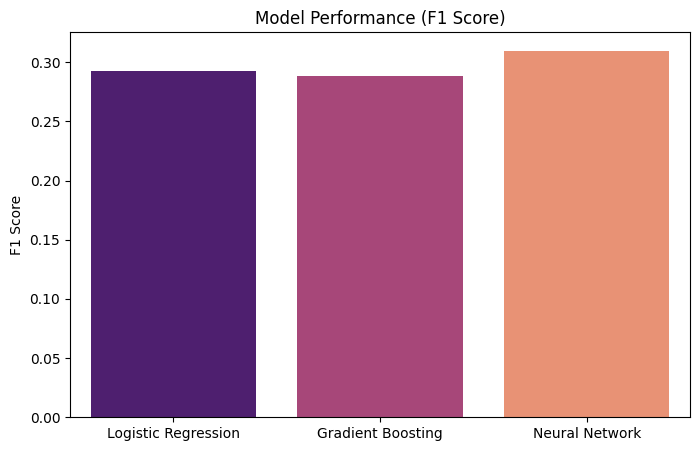

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier # <--- The Replacement
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. SETUP DATA
filename = 'f1_undercut_data_2022_2025.csv'
df = pd.read_csv(filename)

features = [
    'Gap_To_Ahead', 
    'Pit_Aggressiveness', # <--- The new logic
    'StationaryDuration', 
    'InLap_Sec', 
    'OutLap_Sec', 
    'Is_Traffic'
]
ml_data = df.dropna(subset=features + ['Undercut_Successful']).copy()

X = ml_data[features]
y = ml_data['Undercut_Successful']

# Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

results = {}

# 2. MODEL A: Logistic Regression
print("--- Training Logistic Regression ---")
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results['Logistic Regression'] = f1_score(y_test, y_pred_lr)
print("Done.")

# 3. MODEL B: Gradient Boosting (Replaces XGBoost)
print("\n--- Training Gradient Boosting (Sklearn) ---")
# GradientBoostingClassifier doesn't have 'class_weight', so we use sample_weight
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_gb = gb_model.predict(X_test)
results['Gradient Boosting'] = f1_score(y_test, y_pred_gb)
print("Done.")

# 4. MODEL C: Neural Network (MLP)
print("\n--- Training Neural Network ---")
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate weights manually for Keras
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
keras_weights = {0: weights[0], 1: weights[1]}

nn_model.fit(X_train, y_train, epochs=50, batch_size=32, class_weight=keras_weights, verbose=0)

y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")
results['Neural Network'] = f1_score(y_test, y_pred_nn)
print("Done.")

# 5. COMPARE
print("\n--- F1 Score Showdown ---")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')
plt.title('Model Performance (F1 Score)')
plt.ylabel('F1 Score')
plt.show()